# The Dataset:

This project takes audio recordings of speakers saying the digits 0 - 9. My models predict which of the 6 speakers in the dataset is speaking. 

The dataset is called the "Free Spoken Digit Dataset". It includes 3,000 recordings, in .wav files, with minimal silence at the beginning and end of each recording.

The data is available [here.](https://github.com/Jakobovski/free-spoken-digit-dataset)






# Colab Set-Up

In [3]:
%matplotlib inline

# Import Data

In [4]:
# global imports

import os
import sys
import glob
import dill
import librosa
import numpy as np
import matplotlib.pyplot as plt

from os import path
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import OneHotEncoder
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score, KFold, train_test_split

In [5]:
# "Mount" the drive and then unzip it using the following code.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# defining some global variables

PATH = path.abspath(path.join(os.getcwd(), "../.."))

dataset_name = "recordings"
DATA_PATH = path.join(PATH, "/content/drive/MyDrive/Colab Notebooks/ADV Machine Learning/Assignment 4 - Sound/{}".format(dataset_name))

DATA_PATH


'/content/drive/MyDrive/Colab Notebooks/ADV Machine Learning/Assignment 4 - Sound/recordings'

In [7]:
# add root directory to system path

sys.path.append(PATH)

In [8]:
# initialize the set of labels from the speech dataset we are going to train our network
# on

CLASSES = ["george", "nicolas", "theo", "yweweler", "jackson", "lucas"]

for cl in CLASSES:
    assert path.exists(path.join(DATA_PATH, cl)), f"Path does not exist for class {cl}"

In [9]:
## Read Data: 
data = [] ## Set up list instead of Dict

for cl in CLASSES:
    # get list of files in a class directory
    files = glob.glob(path.join(DATA_PATH, cl + "/*"))

    for fp in files:
        # load audio features using librosa
        audio = librosa.load(fp, mono=True, sr=None)[0] # args read in raw audio data without conversions
                                                        # Note that you can also read in audio to a specific length with "duration" argument
        data.append((audio, cl))

In [10]:
len(data)

3000

# Visualize Data Set 

In [11]:
### Visualizing the dataset (confirm load correctly)

counts = [c for _, c in data]
counts = [counts.count(c) for c in CLASSES]

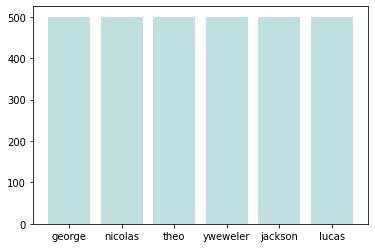

In [12]:
plt.bar(CLASSES, counts, color="#c0e0e0")
plt.show()

# Preprocessing

## Define Preprocessor

In [13]:
def preprocess(data, labels, one_hot_enc=None):
    """
    This function preprocesses the the data to extract mfcc features for each audio
    track and one-hot encodes all the labels
    
    params:
        data
            list of audio waves extracted using librosa
        
        labels
            list of labels (integer or label names)
            
        one_hot_enc
            object that has a method transform which transforms list of labels to their
            one hot encoded form
            
    returns:
        X
            list of transformed features corresponding to data passed as input
        
        y
            list of one-hot encoded labels
        
    """

    if one_hot_enc is None:
        raise ValueError("one_hot_enc cannot be None")

    import librosa
    import numpy as np

    # fix length of audio tracks (pad if shorter, crop if longer)
    X = np.array([librosa.util.fix_length(x, 16000) for x in data])  ## fix the lengths to make equal
    X = np.array([librosa.feature.mfcc(x, sr=16000) for x in X]) #Mel filter cepstral coefficients (MFCC)

## splits waveform up into different freq band
## for each freq band, has different amplitudes 
## fourier (?) transform --> splits up waveform into sine waves 
## A bunch more steps happen 
## eventually use those as features 

    y = np.array([[l] for l in labels])
    y = one_hot_enc.transform(y).toarray()

    return X, y

In [14]:
# define the one-hot encoder

enc = OneHotEncoder(handle_unknown="ignore")
enc.fit(np.array([[cl] for cl in CLASSES]))

OneHotEncoder(handle_unknown='ignore')

## Pre-Process the Data: 

In [15]:
# split the unprocessed data to covariates and labels

data, labels = zip(*data) 

In [16]:
print(data[0].shape)
print(labels[0])

(2706,)
george


In [17]:
# preprocess the data to be used later

X, y = preprocess(data, labels,enc)

In [18]:
X.shape # our mfcc transformation outputs to 32 x input features

(3000, 20, 32)

In [19]:
y.shape

(3000, 6)

## Define Train/Test Split

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

# Predictive Models



## Model #1: Basic LSTM 

In [21]:
# Load libraries
import sys
import time
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import os
import zipfile

from skimage.transform import resize
from sklearn.model_selection import train_test_split

from tensorflow.python.keras.utils import np_utils
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.python.keras.layers import LSTM,Dense, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D 
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
#from tensorflow.python.keras.optimizers import Adagrad,Adadelta,RMSprop



# defining the model
dense_out_3 = len(CLASSES)

model = Sequential()
model.add(LSTM(200))
model.add(Dense(20, activation="relu"))
model.add(Dense(10, activation="relu"))
model.add(Dense(dense_out_3, activation="softmax"))

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [23]:
with tf.device('/device:GPU:0'): 

    history = model.fit(
        X_train,
        y_train,
        epochs=20,
        batch_size=72,
        validation_data=(X_test, y_test),
        verbose=2,
        shuffle=True,
    )

Epoch 1/20
30/30 - 7s - loss: 1.3205 - accuracy: 0.5752 - val_loss: 0.8834 - val_accuracy: 0.7211
Epoch 2/20
30/30 - 4s - loss: 0.6164 - accuracy: 0.8176 - val_loss: 0.4197 - val_accuracy: 0.8944
Epoch 3/20
30/30 - 4s - loss: 0.2453 - accuracy: 0.9410 - val_loss: 0.2293 - val_accuracy: 0.9300
Epoch 4/20
30/30 - 4s - loss: 0.1066 - accuracy: 0.9729 - val_loss: 0.1786 - val_accuracy: 0.9478
Epoch 5/20
30/30 - 4s - loss: 0.0495 - accuracy: 0.9890 - val_loss: 0.1829 - val_accuracy: 0.9467
Epoch 6/20
30/30 - 4s - loss: 0.0472 - accuracy: 0.9895 - val_loss: 0.1513 - val_accuracy: 0.9533
Epoch 7/20
30/30 - 4s - loss: 0.0172 - accuracy: 0.9990 - val_loss: 0.1157 - val_accuracy: 0.9689
Epoch 8/20
30/30 - 4s - loss: 0.0083 - accuracy: 0.9995 - val_loss: 0.1164 - val_accuracy: 0.9656
Epoch 9/20
30/30 - 4s - loss: 0.0055 - accuracy: 1.0000 - val_loss: 0.1243 - val_accuracy: 0.9656
Epoch 10/20
30/30 - 4s - loss: 0.0037 - accuracy: 1.0000 - val_loss: 0.1241 - val_accuracy: 0.9667
Epoch 11/20
30/30 -

## Model #2: Stacked LSTMs

In [24]:
model2 = Sequential()
model2.add(LSTM(200, return_sequences=True))
model2.add(LSTM(200, return_sequences=True))
model2.add(LSTM(200))
model2.add(Dense(20, activation="relu"))
model2.add(Dense(10, activation="relu"))
model2.add(Dense(dense_out_3, activation="softmax"))

model2.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [25]:
with tf.device('/device:GPU:0'): 

    history = model2.fit(
        X_train,
        y_train,
        epochs=20,
        batch_size=72,
        validation_data=(X_test, y_test),
        verbose=2,
        shuffle=True,
    )

Epoch 1/20
30/30 - 24s - loss: 1.1802 - accuracy: 0.5914 - val_loss: 0.8098 - val_accuracy: 0.7411
Epoch 2/20
30/30 - 14s - loss: 0.6289 - accuracy: 0.7895 - val_loss: 0.4892 - val_accuracy: 0.8800
Epoch 3/20
30/30 - 14s - loss: 0.3726 - accuracy: 0.9071 - val_loss: 0.5422 - val_accuracy: 0.8367
Epoch 4/20
30/30 - 14s - loss: 0.2060 - accuracy: 0.9467 - val_loss: 0.2705 - val_accuracy: 0.9233
Epoch 5/20
30/30 - 14s - loss: 0.0969 - accuracy: 0.9733 - val_loss: 0.2151 - val_accuracy: 0.9456
Epoch 6/20
30/30 - 14s - loss: 0.0448 - accuracy: 0.9886 - val_loss: 0.2925 - val_accuracy: 0.9211
Epoch 7/20
30/30 - 14s - loss: 0.0712 - accuracy: 0.9814 - val_loss: 0.2039 - val_accuracy: 0.9522
Epoch 8/20
30/30 - 14s - loss: 0.0323 - accuracy: 0.9924 - val_loss: 0.1458 - val_accuracy: 0.9656
Epoch 9/20
30/30 - 14s - loss: 0.0448 - accuracy: 0.9881 - val_loss: 0.3492 - val_accuracy: 0.9122
Epoch 10/20
30/30 - 14s - loss: 0.0504 - accuracy: 0.9871 - val_loss: 0.1516 - val_accuracy: 0.9600
Epoch 11/

## Model #3: Add Dropout

In [26]:
model3 = Sequential()
model3.add(LSTM(200, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model3.add(LSTM(200, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model3.add(LSTM(200))
model3.add(Dense(20, activation="relu"))
model3.add(Dense(10, activation="relu"))
model3.add(Dense(dense_out_3, activation="softmax"))

model3.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [27]:
with tf.device('/device:GPU:0'): 

    history = model3.fit(
        X_train,
        y_train,
        epochs=20,
        batch_size=72,
        validation_data=(X_test, y_test),
        verbose=2,
        shuffle=True,
    )


Epoch 1/20
30/30 - 27s - loss: 1.2833 - accuracy: 0.4690 - val_loss: 0.9532 - val_accuracy: 0.6478
Epoch 2/20
30/30 - 15s - loss: 0.7240 - accuracy: 0.6771 - val_loss: 0.5965 - val_accuracy: 0.7333
Epoch 3/20
30/30 - 15s - loss: 0.5190 - accuracy: 0.8076 - val_loss: 0.4905 - val_accuracy: 0.8622
Epoch 4/20
30/30 - 16s - loss: 0.3378 - accuracy: 0.9105 - val_loss: 0.4305 - val_accuracy: 0.8567
Epoch 5/20
30/30 - 15s - loss: 0.2270 - accuracy: 0.9305 - val_loss: 0.2686 - val_accuracy: 0.9311
Epoch 6/20
30/30 - 15s - loss: 0.2217 - accuracy: 0.9333 - val_loss: 0.3310 - val_accuracy: 0.9200
Epoch 7/20
30/30 - 16s - loss: 0.1900 - accuracy: 0.9462 - val_loss: 0.2288 - val_accuracy: 0.9333
Epoch 8/20
30/30 - 15s - loss: 0.1229 - accuracy: 0.9619 - val_loss: 0.2199 - val_accuracy: 0.9456
Epoch 9/20
30/30 - 16s - loss: 0.1567 - accuracy: 0.9486 - val_loss: 0.2108 - val_accuracy: 0.9411
Epoch 10/20
30/30 - 16s - loss: 0.1338 - accuracy: 0.9552 - val_loss: 0.1728 - val_accuracy: 0.9622
Epoch 11/

## Model #4: Add Bidirectional Layer

In [31]:
from tensorflow.keras.layers import Bidirectional

model4 = Sequential()
model4.add(Bidirectional(LSTM(200, dropout=0.3, recurrent_dropout=0.3, return_sequences=True)))
model4.add(LSTM(200, dropout=0.25, recurrent_dropout=0.25, return_sequences=True))
model4.add(LSTM(200, dropout=0.2, recurrent_dropout=0.2 ))
model4.add(Dense(20, activation="relu"))
model4.add(Dense(10, activation="relu"))
model4.add(Dense(dense_out_3, activation="softmax"))

model4.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [32]:
checkpoint_filepath = '/tmp/checkpoint'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

# Model weights are saved at the end of every epoch, if it's the best seen so far.

with tf.device('/device:GPU:0'): 

    history = model4.fit(
        X_train,
        y_train,
        epochs=25,
        batch_size=72,
        validation_data=(X_test, y_test),
        verbose=2,
        shuffle=True,
        callbacks=[model_checkpoint_callback],
    )

#Load best weights into model
model4.load_weights(checkpoint_filepath)


Epoch 1/25
30/30 - 41s - loss: 1.1857 - accuracy: 0.5205 - val_loss: 0.8300 - val_accuracy: 0.7300
Epoch 2/25
30/30 - 24s - loss: 0.6170 - accuracy: 0.7967 - val_loss: 0.4705 - val_accuracy: 0.8367
Epoch 3/25
30/30 - 24s - loss: 0.4005 - accuracy: 0.8581 - val_loss: 0.3686 - val_accuracy: 0.8778
Epoch 4/25
30/30 - 23s - loss: 0.2775 - accuracy: 0.9071 - val_loss: 0.2764 - val_accuracy: 0.9056
Epoch 5/25
30/30 - 23s - loss: 0.2292 - accuracy: 0.9243 - val_loss: 0.1977 - val_accuracy: 0.9300
Epoch 6/25
30/30 - 24s - loss: 0.1719 - accuracy: 0.9462 - val_loss: 0.2633 - val_accuracy: 0.9233
Epoch 7/25
30/30 - 23s - loss: 0.1638 - accuracy: 0.9476 - val_loss: 0.1108 - val_accuracy: 0.9644
Epoch 8/25
30/30 - 24s - loss: 0.1432 - accuracy: 0.9510 - val_loss: 0.1260 - val_accuracy: 0.9556
Epoch 9/25
30/30 - 23s - loss: 0.1107 - accuracy: 0.9633 - val_loss: 0.1316 - val_accuracy: 0.9533
Epoch 10/25
30/30 - 23s - loss: 0.0657 - accuracy: 0.9771 - val_loss: 0.0854 - val_accuracy: 0.9700
Epoch 11/

In [33]:
model4.evaluate(X_test, y_test)
# confirm loaded weights

29/29 [==============================] - 2s 72ms/step - loss: 0.0738 - accuracy: 0.9789


[0.07383837550878525, 0.9788888692855835]

# Reflection

The best performing model was Model 4, which had one bidirectional LSTM layer, two regular LSTM layers, and 3 dense layers. It had a validation accuracy of 97.89%. 

The worst performing model was Model 3, which had three stacked LSTM layers, two of which had dropout, and 3 dense layers. It had an a validation accuracy of 95.67%. 

All things considered, if I had to choose one model to use in production, I would probably go with Model 2. It's validation accuracy was comparable to model 4 (97.44% as compared to 97.89%), but it was a lot faster to train because the LSTM layers didn't have dropout, and it is marginally simpler because there are no bidirectional layers. 